In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np




## Load Dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Helper Functions

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

## Load train and test

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)



## General settings

In [ ]:
# Define batch size for training and validation
BATCH_SIZE = 64

# Define buffer size for shuffling the dataset
BUFFER_SIZE = 1000

# Prepare training batches
train_batches = train_dataset.cache()  # Cache dataset to improve performance
train_batches = train_batches.shuffle(BUFFER_SIZE)  # Shuffle dataset to ensure randomness
train_batches = train_batches.batch(BATCH_SIZE).repeat()  # Batch and repeat dataset for multiple epochs
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch to overlap data preprocessing and model training

# Prepare validation batches
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)  # Take first 3000 examples and batch

# Prepare test batches
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)  # Skip first 3000 examples, take next 669 examples, and batch


In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Layer and model functions


In [ ]:
# Function to apply two convolutional layers with ReLU activation
def double_conv_block(x, n_filters):
    # Apply the first convolutional layer
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    # Apply the second convolutional layer
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    # Using two convolutional layers helps the model learn more complex features.
    # The ReLU activation introduces non-linearity, allowing the network to learn a wider range of patterns.
    return x

# Skip connections

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)  # Apply double convolution
    p = layers.MaxPool2D(2)(f)  # Downsample using max pooling
    p = layers.Dropout(0.3)(p)  # Apply dropout for regularization
    return f, p  # Return feature map and pooled output

In [ ]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)  # Upsample
    # concatenate - this is where the skip connection is implemented

    x = layers.concatenate([x, conv_features])  # Add skip connection
    x = layers.Dropout(0.3)(x)  # Apply dropout for regularization
    x = double_conv_block(x, n_filters)  # Apply double convolution
    return x

## Breakdown



```
f1, p1 = downsample_block(inputs, 64)

```

**F1**: feature map,  **P1**: pooled output



```
x = layers.concatenate([x, conv_features])

```

 The **conv_features** represents feature maps from the corresponding layer in the encoder. These feature maps are rich in spatial information that was learned during the downsampling path (encoder).

 This line takes the **upsampled feature maps (x)** from the decoder and concatenates them with the **feature maps (conv_features)** from the encoder. By doing this, it effectively creates a skip connection between the encoder and decoder layers.

In [16]:
def build_unet_model():
    # Input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder (Downsampling Path)
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder (Upsampling Path)
    u6 = upsample_block(bottleneck, f4, 512)  # Skip connection from f4
    u7 = upsample_block(u6, f3, 256)         # Skip connection from f3
    u8 = upsample_block(u7, f2, 128)         # Skip connection from f2
    u9 = upsample_block(u8, f1, 64)          # Skip connection from f1

    # Output layer
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

    # Create model
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

# Build the U-Net model
unet_model = build_unet_model()
unet_model.summary()

In [17]:
unet_model = build_unet_model()


In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [19]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 135s 1s/step - loss: 3.8840 - accuracy: 0.5195 - val_loss: 0.9009 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 91s 1s/step - loss: 0.9121 - accuracy: 0.5859 - val_loss: 0.8550 - val_accuracy: 0.5858
Epoch 3/20
57/57 [==============================] - 65s 1s/step - loss: 0.8016 - accuracy: 0.6329 - val_loss: 0.7604 - val_accuracy: 0.6567
Epoch 4/20
57/57 [==============================] - 72s 1s/step - loss: 0.7284 - accuracy: 0.6861 - val_loss: 0.6939 - val_accuracy: 0.7074
Epoch 5/20
57/57 [==============================] - 67s 1s/step - loss: 0.6921 - accuracy: 0.7121 - val_loss: 0.6751 - val_accuracy: 0.7211
Epoch 6/20
57/57 [==============================] - 65s 1s/step - loss: 0.6564 - accuracy: 0.7324 - val_loss: 0.6378 - val_accuracy: 0.7449
Epoch 7/20
57/57 [==============================] - 75s 1s/step - loss: 0.6295 - accuracy: 0.7461 - val_loss: 0.5916 - val_accuracy: 0.7683
Epoch 8/20
57/57 [=

In [20]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]
def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


In [22]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

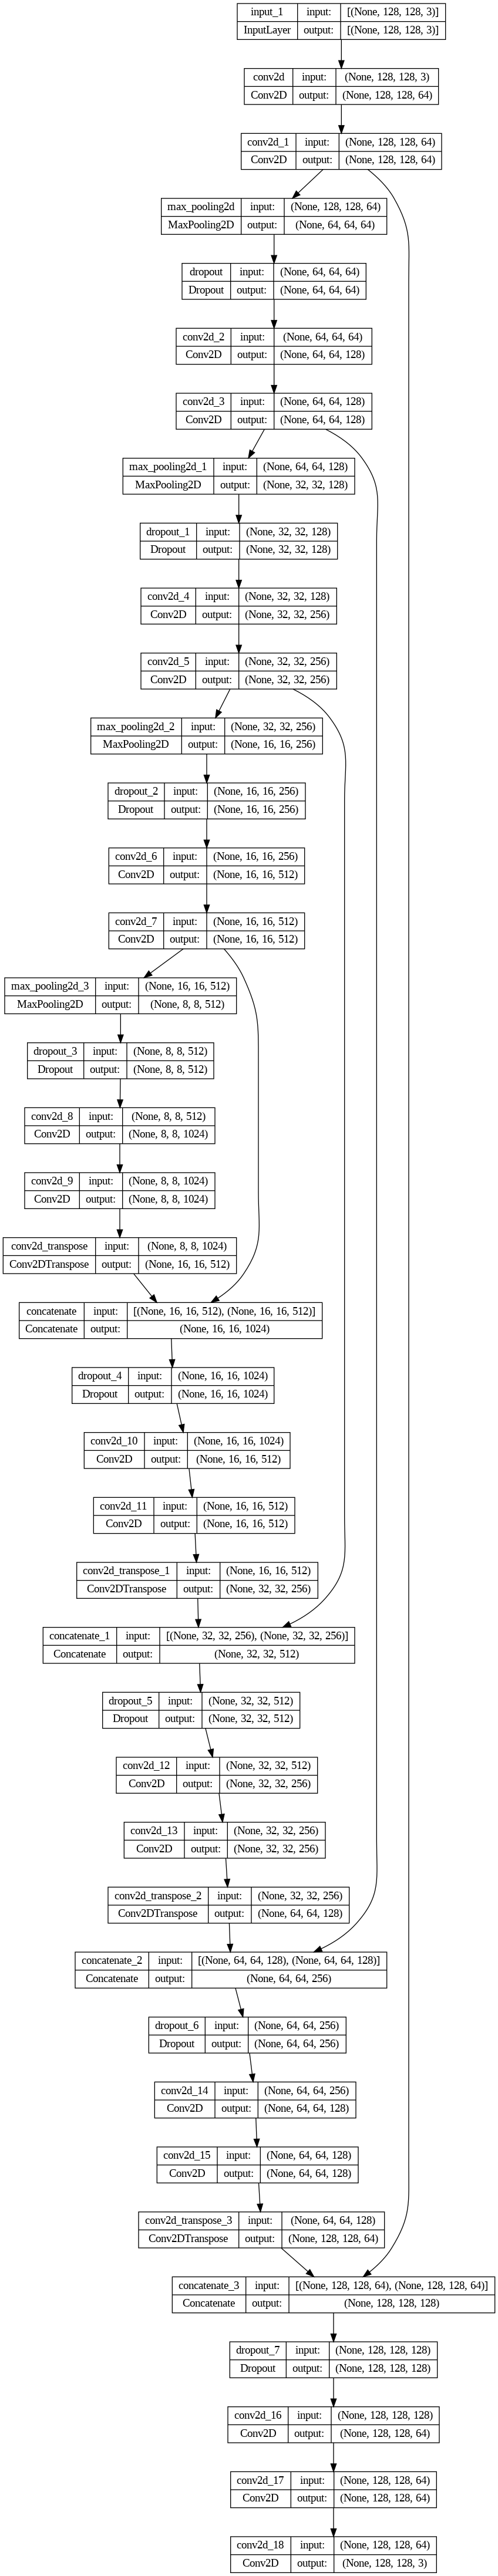

In [23]:
from tensorflow.keras import layers, models, utils
# Visualize the model architecture with summary
unet_model.summary()

# Generate and visualize the model diagram
utils.plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

# Display the generated model diagram inline (useful in Jupyter or Colab)
from IPython.display import Image
Image(filename='unet_model.png')

2/2 [==============================] - 1s 9ms/step


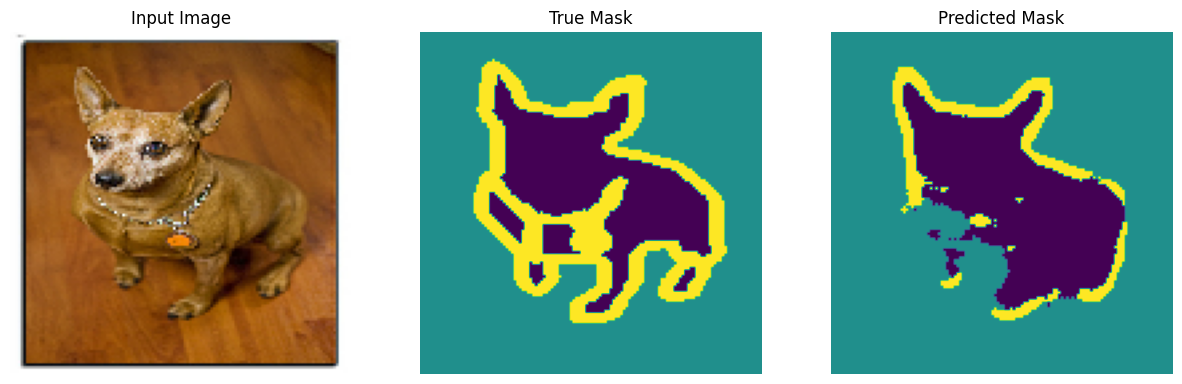

2/2 [==============================] - 0s 134ms/step


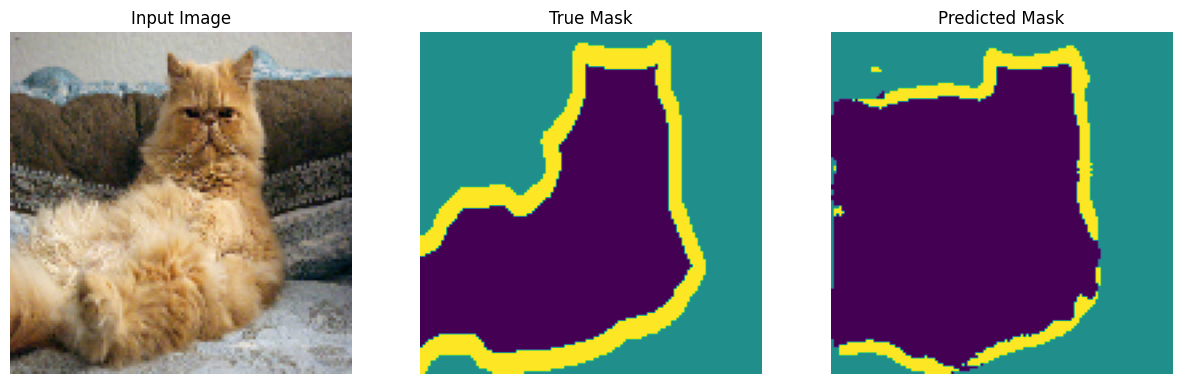

2/2 [==============================] - 0s 124ms/step


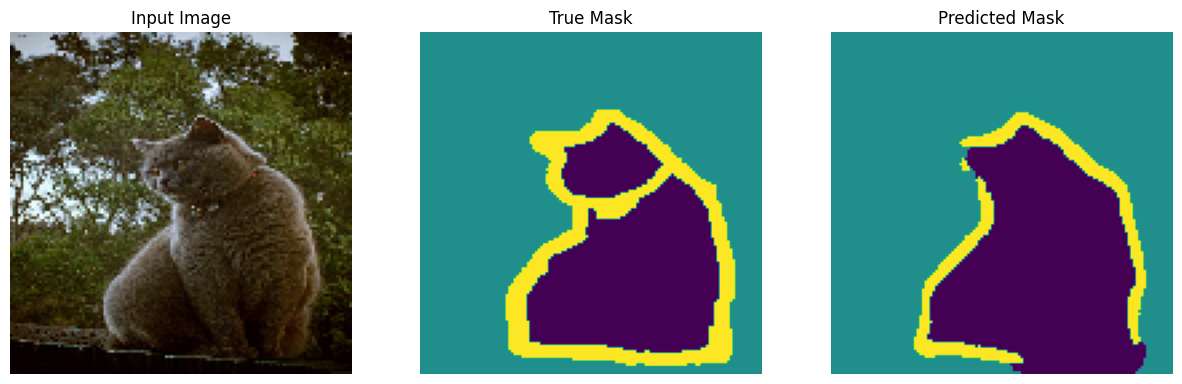

In [24]:
show_predictions(test_batches, num=3)  # Adjust 'num' to see more or fewer examples


In [25]:
unet_model.save('unet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('unet_model.h5')
